In [1]:
import sys
import os
from glob import glob

import warnings

import matplotlib as mpl

import re

import seaborn as sns

from pyprojroot.here import here

import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = '#FFFFFF'

import pandas as pd
import numpy as np

from PyComplexHeatmap import *

from sklearn.metrics import balanced_accuracy_score, f1_score

# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

from customPalette import diseases_palette, diseaseCategories, diseasesGroup_palette, COVID_severity_palette

dpi_fig_save = 300

In [2]:
!pwd

/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/COMBAT_focus_analysis


### Loading dataframes with labels

In [3]:
pred_file_path_list = glob(str(here('03_downstream_analysis/08_gene_importance/COMBAT_focus_analysis/results/predictions/*_pred_test.zip')))

In [4]:
predictionDFlist = []
for pt in pred_file_path_list: 
    fn = os.path.basename(pt)
    split_id = fn.split('_')[0]
    ct = fn.split('_', maxsplit= 1)[1].replace('_pred_test.zip','')
    df_i = pd.read_csv(pt, index_col=0)

    df_i['Level1'] = ct
    df_i['SPLIT_ID'] = split_id

    predictionDFlist.append(df_i)

predictionDF = pd.concat(predictionDFlist, axis=0)

dis_cod_dict = predictionDF[['y_true','y_true_code']].drop_duplicates().set_index('y_true_code').to_dict()['y_true']

predictionDF['disease'] = predictionDF.y_true_code.map(dis_cod_dict)
predictionDF['disease_pred'] = predictionDF.y_pred.map(dis_cod_dict)
predictionDF.drop(['y_true','y_true_code','y_pred'], axis=1,inplace=True)


# predictionDF = predictionDF.rename({'y_true':'disease', 'y_pred':'disease_pred'}, axis=1)

In [5]:
predictionDF['disease_cat'] = predictionDF.disease.map(diseaseCategories)

**Overall BAS and Weighted F1:**

In [6]:
print(f"BAS COMBAT data: {balanced_accuracy_score(y_true = predictionDF.disease, y_pred=predictionDF.disease_pred)}")
print(f"W_F1 COMBAT data: {f1_score(y_true = predictionDF.disease, y_pred=predictionDF.disease_pred, average='weighted')}")

BAS COMBAT data: 0.5688384471983392
W_F1 COMBAT data: 0.7770090481161247


**BAS for each cell-type**

In [7]:
predictionDF.groupby(['Level1'])[['disease','disease_pred']].apply(lambda x: (balanced_accuracy_score(y_true = x.disease.astype(str),
                                                                                                       y_pred = x.disease_pred.astype(str))))

Level1
B                 0.462546
DC                0.560193
ILC               0.499521
Mono              0.615353
Plasma            0.266519
T_CD4_Naive       0.589718
T_CD4_NonNaive    0.555182
T_CD8_Naive       0.542080
T_CD8_NonNaive    0.497255
UTC               0.464551
pDC               0.453141
dtype: float64

**Weighted F1, for each cell-type**

In [8]:
predictionDF.groupby(['Level1'])[['disease','disease_pred']].apply(lambda x: (f1_score(y_true = x.disease.astype(str),
                                                                                   y_pred = x.disease_pred.astype(str),
                                                                                   average='weighted')))

Level1
B                 0.769674
DC                0.825686
ILC               0.760036
Mono              0.769111
Plasma            0.661389
T_CD4_Naive       0.815074
T_CD4_NonNaive    0.805129
T_CD8_Naive       0.774824
T_CD8_NonNaive    0.722134
UTC               0.732579
pDC               0.739218
dtype: float64

## Confusion matrix visualization

#### Functions

In [9]:
# Computing the confusion matrix
def getConfusionMatrix(predTestDF = None, predCol = 'y_pred', gtCol = 'y_test', normalize='columns'):

    # normalize could be False, 'rows', or 'columns' (default).
    
    import pandas as pd

    if normalize == False:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], dropna=False)
    else:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], normalize=normalize, dropna=False)

    if confusionMatrix.shape[0] < confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.columns.tolist(), confusionMatrix.index.tolist()):
            confusionMatrix.loc[d,:] = 0
    elif confusionMatrix.shape[0] > confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.index.tolist(),confusionMatrix.columns.tolist()):
            confusionMatrix[d] = 0   

    return(confusionMatrix)

In [10]:
def reorder_ConfMatrix(confusionMatrix=None, elementList = None):

    confusionMatrix = confusionMatrix.reindex(elementList, axis=0).reindex(elementList, axis=1)

    return(confusionMatrix)

In [11]:
def mask_entries(confusionMatrix=None, lowerThan = 0, cmap='viridis'):
    confusionMatrix_nan = confusionMatrix.copy()
    confusionMatrix_nan[confusionMatrix_nan <= lowerThan] = np.nan
    return(confusionMatrix_nan)
    

#### Changing the PyComplexHeatmap code

https://dingwb.github.io/PyComplexHeatmap/build/html/notebooks/composite_heatmaps.html#Composite-two-heatmaps-horizontally-for-mouse-DNA-methylation-array-dataset

The following change is required to avoid reordering columns and rows. So, disease in the same category are close to each others

In [12]:
def _reorder_rows(self):
    self.row_split_dendrogram = False
    if self.verbose >= 1:
        print("Reordering rows..")
    if self.row_split is None and self.row_cluster:
        self.calculate_row_dendrograms(
            self.data2d
        )  # xind=self.dendrogram_row.reordered_ind
        self.row_order = [
            self.dendrogram_row.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.row_split, int) and self.row_cluster:
        self.calculate_row_dendrograms(self.data2d)
        self.row_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_row.linkage,
                    t=self.row_split,
                    criterion="maxclust",
                ),
                index=self.data2d.index.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_row.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.row_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.row_split, pd.Series):
            self.row_split = self.row_split.to_frame(name=self.row_split.name)
        cols = self.row_split.columns.tolist()
        row_clusters = self.row_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.row_split_order is None:
            self.row_split_order = row_clusters.index.tolist()
        elif self.row_split_order == 'cluster_between_groups':
            mat=pd.concat([
                self.data2d.loc[rows].mean() for rows in row_clusters.tolist()],
                          axis=1).T #columns are original columns
            mat.index=row_clusters.index.tolist()
            sizes=row_clusters.apply(lambda x:len(x)).tolist()
            self.calculate_row_dendrograms(mat,sizes=sizes)
            self.row_split_order = self.dendrogram_row.dendrogram["ivl"]
            self.row_split_dendrogram=self.dendrogram_row
        self.row_clusters = row_clusters.loc[self.row_split_order].to_dict()
    elif not self.row_cluster:
        self.row_order = [self.data2d.index.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.row_order = []
    self.dendrogram_rows = []
    for i, cluster in enumerate(self.row_clusters):
        rows = self.row_clusters[cluster]
        if len(rows) <= 1:
            self.row_order.append(rows)
            self.dendrogram_rows.append(None)
            continue
        if self.row_cluster: #cluster within groups
            self.calculate_row_dendrograms(self.data2d.loc[rows])
            self.dendrogram_rows.append(self.dendrogram_row)
            self.row_order.append(self.dendrogram_row.dendrogram["ivl"])
        else:
            self.row_order.append(rows)

def _reorder_cols(self):
    self.col_split_dendrogram=False
    if self.verbose >= 1:
        print("Reordering cols..")
    if self.col_split is None and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_order = [
            self.dendrogram_col.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.col_split, int) and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_col.linkage,
                    t=self.col_split,
                    criterion="maxclust",
                ),
                index=self.data2d.columns.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_col.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.col_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.col_split, pd.Series):
            self.col_split = self.col_split.to_frame(name=self.col_split.name)
        cols = self.col_split.columns.tolist()
        col_clusters = self.col_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.col_split_order is None:
            self.col_split_order = col_clusters.index.tolist()
        elif self.col_split_order == 'cluster_between_groups':
            mat = pd.concat([
                self.data2d.loc[:,cols].mean(axis=1) for cols in col_clusters.tolist()],
                axis=1)  # index are original rows labels
            mat.columns = col_clusters.index.tolist()
            sizes = col_clusters.apply(lambda x: len(x)).tolist()
            self.calculate_col_dendrograms(mat, sizes=sizes)
            self.col_split_order = self.dendrogram_col.dendrogram["ivl"]
            self.col_split_dendrogram = self.dendrogram_col
        self.col_clusters = col_clusters.loc[self.col_split_order].to_dict()
    elif not self.col_cluster:
        self.col_order = [self.data2d.columns.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.col_order = []
    self.dendrogram_cols = []
    for i, cluster in enumerate(self.col_clusters):
        cols = self.col_clusters[cluster]
        if len(cols) <= 1:
            self.col_order.append(cols)
            self.dendrogram_cols.append(None)
            continue
        if self.col_cluster:
            self.calculate_col_dendrograms(self.data2d.loc[:, cols])
            self.dendrogram_cols.append(self.dendrogram_col)
            self.col_order.append(self.dendrogram_col.dendrogram["ivl"])
        else:
            self.col_order.append(cols)

def plot_matrix(self, row_order, col_order):
    col_order=row_order.copy()
    if self.verbose >= 1:
        print("Plotting matrix..")
    nrows = len(row_order)
    ncols = len(col_order)
    self.wspace = (
        self.col_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().width / ncols)
    )  # 1mm=mm2inch inch
    self.hspace = (
        self.row_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().height / nrows)
    )  # height
    self.heatmap_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
        nrows,
        ncols,
        hspace=self.hspace,
        wspace=self.wspace,
        subplot_spec=self.gs[1, 1],
        height_ratios=[len(rows) for rows in row_order],
        width_ratios=[len(cols) for cols in col_order],
    )

    annot = self.kwargs.pop("annot", None)
    if annot is None or annot is False:
        pass
    else:
        if isinstance(annot, bool):
            annot_data = self.data2d
        else:
            annot_data = annot.copy()
            if annot_data.shape != self.data2d.shape:
                err = "`data` and `annot` must have same shape."
                raise ValueError(err)

    self.heatmap_axes = np.empty(shape=(nrows, ncols), dtype=object)
    # if nrows > 1 or ncols > 1:
    self.ax_heatmap.set_axis_off()
    for i, rows in enumerate(row_order):
        for j, cols in enumerate(col_order):
            # print(i,j)
            ax1 = self.ax_heatmap.figure.add_subplot(
                self.heatmap_gs[i, j],
                sharex=self.heatmap_axes[0, j],
                sharey=self.heatmap_axes[i, 0],
            )
            ax1.set_xlim([0, len(rows)])
            ax1.set_ylim([0, len(cols)])
            annot1 = None if annot is None else annot_data.loc[rows, cols]
            # heatmap(self.data2d.loc[rows, cols], ax=ax1, cbar=False, cmap=self.cmap,
            #         cbar_kws=None, mask=self.mask.loc[rows, cols], rasterized=self.rasterized,
            #         xticklabels='auto', yticklabels='auto', annot=annot1, **self.kwargs)
            plot_heatmap(
                self.data2d.loc[rows, cols],
                ax=ax1,
                cmap=self.cmap,
                mask=self.mask.loc[rows, cols],
                rasterized=self.rasterized,
                xticklabels="auto",
                yticklabels="auto",
                annot=annot1,
                **self.kwargs
            )
            self.heatmap_axes[i, j] = ax1
            ax1.yaxis.label.set_visible(False)
            ax1.xaxis.label.set_visible(False)
            ax1.tick_params(
                left=False,
                right=False,
                labelleft=False,
                labelright=False,
                top=False,
                bottom=False,
                labeltop=False,
                labelbottom=False,
            )


In [13]:
ClusterMapPlotter._reorder_rows = _reorder_rows
ClusterMapPlotter._reorder_cols = _reorder_cols
# ClusterMapPlotter.plot_matrix = plot_matrix

## Overall confusion matrix
Heatmap with accuracy score considering all cell-types and all datasets

In [14]:
elementList = ['healthy'] + [d for d in predictionDF[['disease','disease_cat']].drop_duplicates().sort_values(['disease_cat','disease']).disease.tolist() if d != 'healthy']
diseaseCatOrd =  ['healthy'] + [d for d in predictionDF[['disease','disease_cat']].drop_duplicates().sort_values(['disease_cat','disease']).disease_cat.tolist() if d != 'healthy']

In [15]:
rowAnnDF = predictionDF[['disease','disease_cat']].drop_duplicates().reset_index().set_index('disease')

row_ann = HeatmapAnnotation(disease_group=anno_simple(rowAnnDF.disease_cat,colors=diseasesGroup_palette,rasterized=True, legend_kws={'color_text':False, 'labelcolor':'black'}),#, legend_kws  = {'title': 'Disease\ngroups'}), 
                            axis=0,verbose=0, label_kws={'text':None}, plot=False, legend=True)

### log-scaled data

In [16]:
Overall_confusionMatrix = getConfusionMatrix(predTestDF= predictionDF, predCol = 'disease_pred', gtCol = 'disease')
Overall_confusionMatrix_ord = reorder_ConfMatrix(mask_entries(Overall_confusionMatrix, lowerThan = -1), elementList=elementList)

In [17]:
Overall_confusionMatrix_ord.loc['flu','flu']

0.08576942725776239

In [18]:
Overall_confusionMatrix_ord.loc[:,'flu']

disease_pred
healthy    0.069365
sepsis     0.318045
COVID      0.526821
flu        0.085769
Name: flu, dtype: float64

In [23]:
Overall_confusionMatrix_ord.loc[:,'COVID']

disease_pred
healthy    0.031744
sepsis     0.043890
COVID      0.919440
flu        0.004926
Name: COVID, dtype: float64

In [19]:
Overall_confusionMatrix_ord.loc['sepsis','sepsis']

0.5704434946617986

In [20]:
predictionDF.disease.value_counts()

disease
COVID      345890
sepsis     115582
healthy     86334
flu         17617
Name: count, dtype: int64

In [21]:
predictionDF.disease.value_counts(normalize=True)

disease
COVID      0.611737
sepsis     0.204417
healthy    0.152689
flu        0.031157
Name: proportion, dtype: float64

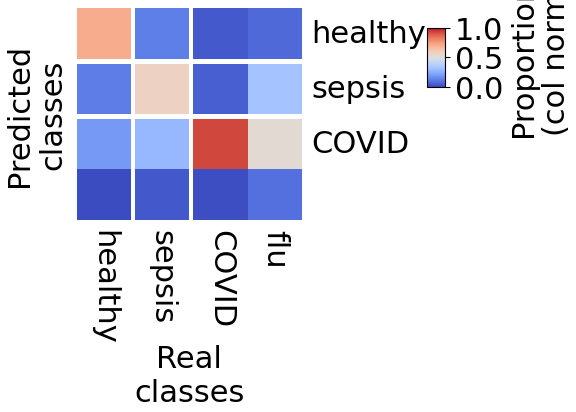

In [30]:
mpl.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = '22'

plt.figure(figsize=(3,2.5))
cm = ClusterMapPlotter(data=Overall_confusionMatrix_ord, 
                       # right_annotation=row_ann, 
                       # top_annotation=col_ann, 
                       row_split=rowAnnDF.disease_cat, row_split_order=diseaseCatOrd,
                       col_split=rowAnnDF.disease_cat, col_split_order=diseaseCatOrd,
                       show_rownames=True,show_colnames=True, xlabel = 'Real\nconditions', ylabel = 'True\nconditions',
                       plot=True, fmt=None,
                       row_cluster=False, col_cluster=False, standard_scale = None,
                       row_dendrogram=False,col_dendrogram=False, verbose=False,
                       cmap='coolwarm', rasterized=False, row_split_gap=1, col_split_gap=1, legend=True, label = 'Proportion\n(col norm)', legend_vpad=5,
                       vmax = 1, vmin = 0)  

plt.savefig(here("03_downstream_analysis/08_gene_importance/COMBAT_focus_analysis/figures/overallConfusionMatrix.svg"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

In [33]:
cellTypeList = list(np.sort(predictionDF.Level1.unique()))
cellTypeList

['B',
 'DC',
 'ILC',
 'Mono',
 'Plasma',
 'T_CD4_Naive',
 'T_CD4_NonNaive',
 'T_CD8_Naive',
 'T_CD8_NonNaive',
 'UTC',
 'pDC']

### Generating the heatmaps

B
DC
ILC
Mono
Plasma
T_CD4_Naive
T_CD4_NonNaive
T_CD8_Naive
T_CD8_NonNaive
UTC
pDC
Plotting ...
Estimated legend width: 7.5 mm


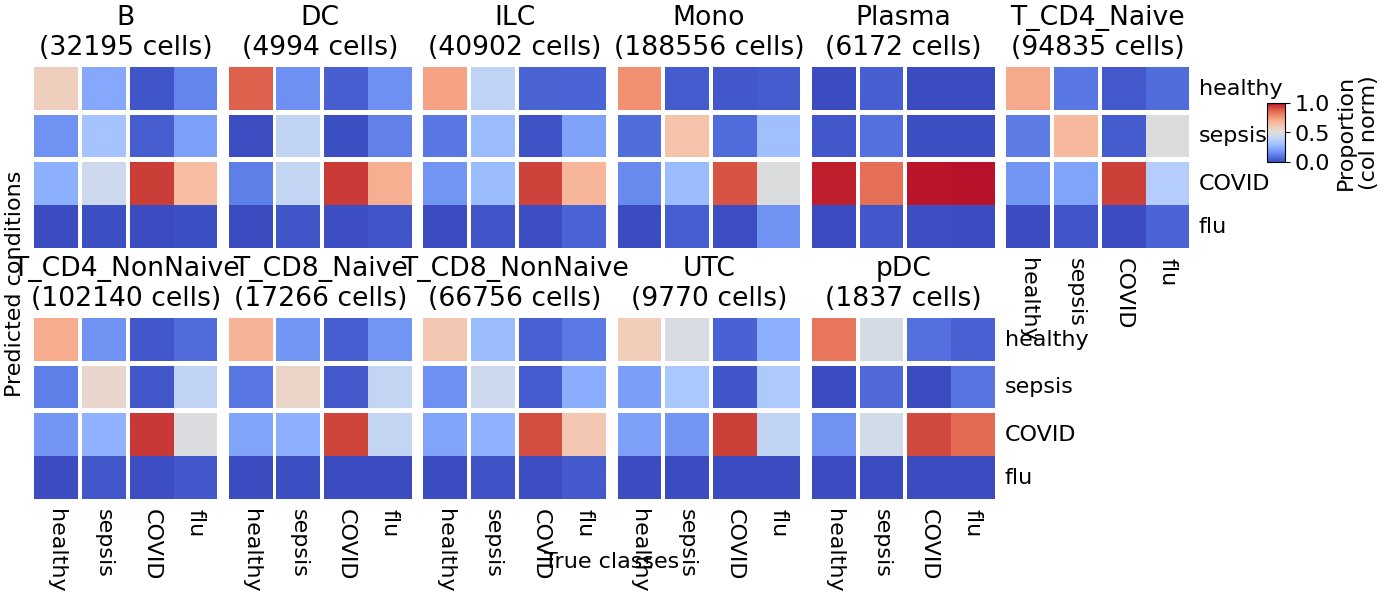

In [49]:
nCol = 7 #max(np.ceil((len(cellTypeList)+1) / 2).astype(int),1)
nRow = len(cellTypeList) // nCol + (len(cellTypeList) % nCol > 0)

mpl.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = '16'

wholeCM = list()
wholeCT = list()
confusionMatrixXct = dict()
for r in range(nRow):
    rowCM = list()
    rowCT = list()
    for c in range(nCol):

        idx = ((nCol*r) + c)

        if idx >= len(cellTypeList):
            continue
        
        ct_i = cellTypeList[idx]

        print(ct_i)
        
        idxCellType = predictionDF.Level1==ct_i
        confusionMatrix_i = getConfusionMatrix(predTestDF= predictionDF.loc[idxCellType,:],  predCol = 'disease_pred', gtCol = 'disease')
        confusionMatrix_i.fillna(0, inplace=True)
        confusionMatrix_i_ord = reorder_ConfMatrix(mask_entries(confusionMatrix_i, lowerThan = -1), elementList=elementList)
        
        totCell = np.sum(idxCellType)

        ################# Annotations

        ################# 

        showRownames = False
        if (c == (nCol-1)) | (((nCol*r) + c+1) >= len(cellTypeList)):
            showRownames = True

        showColnames = False
        if (r == (nRow-1)) | (((nCol*(r+1)) + c) >= len(cellTypeList)):
            showColnames = True

        leftAnnotation = None
        if (c == 0):
            leftAnnotation = row_ann

        confusionMatrixXct[ct_i] = confusionMatrix_i_ord
        cm_i = ClusterMapPlotter(data=confusionMatrix_i_ord, 
                                 # left_annotation=leftAnnotation, 
                                 # top_annotation=col_ann, 
                                 row_split=rowAnnDF.disease_cat, row_split_order=diseaseCatOrd,
                                 col_split=rowAnnDF.disease_cat, col_split_order=diseaseCatOrd,
                                 show_rownames=showRownames,show_colnames=showColnames, 
                                 plot=False, fmt=None,
                                 row_cluster=False, col_cluster=False, standard_scale = None,
                                 row_dendrogram=False,col_dendrogram=False, verbose=False, cmap='coolwarm', rasterized=False, row_split_gap=1, col_split_gap=1,
                                 legend=True, label = 'Proportion\n(col norm)',legend_anchor='ax_heatmap',legend_vpad=5,
                                 vmax = 1, vmin = 0)            

        rowCM.append(cm_i)
        rowCT.append('{}\n({} cells)'.format(ct_i, totCell))
    wholeCM.append(rowCM)
    wholeCT.append(rowCT)
            

print('Plotting ...')

mm2inch = 1 / 25.4

row_gap = 16
col_gap = 12

nR = len(wholeCM)
nC = len(wholeCM[0])

plt.figure(figsize=(15,5))

ax = plt.gca()

wspace = mm2inch * ax.figure.dpi / (ax.get_window_extent().width / nC)
hspace = row_gap * mm2inch * ax.figure.dpi / (ax.get_window_extent().height / nR)


gs = ax.figure.add_gridspec(
    nR,
    nC,
    width_ratios=[1 for i in range(nC)],
    height_ratios=[1 for i in range(nR)],
    wspace=wspace,
    hspace=hspace,
)

for r in range(nR):
    for c in range(nC):

        idx = ((nCol*r) + c)
        
        if idx >= len(cellTypeList):
            continue
        
        ax1 = ax.figure.add_subplot(gs[r,c], sharex=None, sharey=None)
        wholeCM[r][c].plot(ax =ax1, subplot_spec=gs[r,c])
        wholeCM[r][c].ax.set_title(wholeCT[r][c])

        if (r==0) and (c==0):
            label_max_width = ax.figure.get_window_extent().width * wholeCM[r][c].label_max_width / wholeCM[r][c].ax.figure.get_window_extent().width
            legend_list = wholeCM[r][c].legend_list
        
        ax1.set_axis_off()
        
space = col_gap * mm2inch * ax.figure.dpi + label_max_width + 20
plot_legend_list(legend_list, ax=ax, space=space, legend_side='right', gap=15, y0=0.8, legend_width=None)

ax.set_ylabel('Predicted conditions')
ax.set_xlabel('True conditions', labelpad = 35)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.savefig(here("03_downstream_analysis/08_gene_importance/COMBAT_focus_analysis/figures/confusionMatrix_cellTypes.svg"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)